<a href="https://colab.research.google.com/github/thekishanpatel/Projects/blob/master/Time_Series_Analysis_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and SetUp**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive/My Drive/Stock Data/SPY.csv"

Mounted at /content/gdrive


In [0]:
def mse(ypred, yact): return ((ypred-yact)**2).mean()

In [0]:
def mseperct(ypred, yact): return ((np.abs(ypred - yact)/yact) / yact).mean() * 100

In [0]:
def predaccuracy(ypred, yact): return (ypred/yact) * 100

In [0]:
def trendaccuracy(ypred, yact):
  t = 0; j = 0

  for i in range(1, len(ypred), 1):
    if np.sign(ypred[i] - ypred[i-1]) == np.sign(yact[i] - yact[i - 1]):
      t += 1
    j += 1
  return (t / j) * 100

In [0]:
def downtrendaccuracy(ypred, yact):
  t = 0; j = 0;

  for i in range(1, len(ypred), 1):
    if (np.sign(yact[i] - yact[i - 1]) == -1 ):
      j += 1
      if (np.sign(ypred[i] - ypred[i-1]) == -1):
        t += 1
  return ((t / j) * 100), j

In [0]:
def uptrendaccuracy(ypred, yact):
  t = 0; j = 0;

  for i in range(1, len(ypred), 1):
    if (np.sign(yact[i] - yact[i - 1]) == 1 ):
      j += 1
      if (np.sign(ypred[i] - ypred[i-1]) == 1):
        t += 1
  return ((t / j) * 100), j

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline

# **Import Data**

In [0]:
data = pd.read_csv(path, index_col = ['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.453930,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.642057,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.698507,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.980742,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,27.093624,531500
1993-02-05,44.96875,45.06250,44.71875,44.96875,27.074818,492100
1993-02-08,44.96875,45.12500,44.90625,44.96875,27.074818,596100
1993-02-09,44.81250,44.81250,44.56250,44.65625,26.886669,122100
1993-02-10,44.65625,44.75000,44.53125,44.71875,26.924292,379600


In [0]:
drop = ['Adj Close', 'Volume']
data.drop(drop, axis = 1, inplace=True)
data.head(5)

,Open,High,Low,Close
Date,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750
1993-02-01,43.96875,44.25000,43.96875,44.25000
1993-02-02,44.21875,44.37500,44.12500,44.34375
1993-02-03,44.40625,44.84375,44.37500,44.81250
1993-02-04,44.96875,45.09375,44.46875,45.00000


In [0]:
data['Average'] =  data[['Open', 'Close']].mean(axis=1)
data.head(5)

,Open,High,Low,Close,Average
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,43.953125
1993-02-01,43.96875,44.25000,43.96875,44.25000,44.109375
1993-02-02,44.21875,44.37500,44.12500,44.34375,44.281250
1993-02-03,44.40625,44.84375,44.37500,44.81250,44.609375
1993-02-04,44.96875,45.09375,44.46875,45.00000,44.984375


# **Lets First Look at the Data**

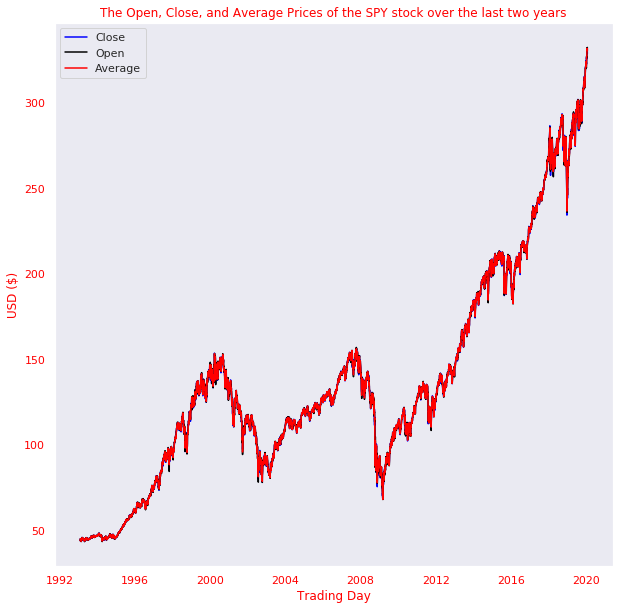

In [0]:
plt.figure(figsize=(10,10))
plt.plot(data.Close, c = "blue")
plt.plot(data.Open, c = "black")
plt.plot(data.Average, c = "red")
plt.title("The Open, Close, and Average Prices of the SPY stock over the last two years", c = "red")
plt.xlabel("Trading Day", c = "red")
plt.ylabel("USD ($)", c = "red")
plt.legend(("Close", "Open", "Average"), loc = 'upper left')
plt.tick_params(axis = 'both', colors = 'red')
plt.rcParams['axes.facecolor'] ='c'
plt.grid(False)
plt.show()

After Looking at the graph, we can see that the 'Average' of the open and close prices, is a decent representation of AMD's price for the day. Moving forward, we will work with the 'Average' price.


# **Let's Get to the Moving Average**

The moving-average, or rather moving-averages, are sucessive average calculated over successive segments of the dataset--the segments are of constant size, which here we refer to as "Windows"

In [0]:
def plt_ma(data, winsize, plt_int = False, scale = 1.96):
  roll_mean = data.rolling(window = winsize).mean()

  plt.figure(figsize=(10,10))
  plt.title("Moving Aveage, Window Size = {}.".format(winsize), c = 'red')
  plt.plot(roll_mean, c = 'blue', label = "Moving Average")
  plt.plot(data[winsize:], c = 'black', label = "Actual Price")

  if plt_int:
    mae = mean_absolute_error(data[winsize:], roll_mean[winsize:])
    dev = np.std(data[winsize:] - roll_mean[winsize:])
    lb = roll_mean - (mae + scale*dev)
    ub = roll_mean + (mae + scale*dev)
    plt.plot(lb, 'r--', label = "Upper/Lowe Bounds")
    plt.plot(ub, 'r--')
  
  plt.xlabel("Trading Day", c = "red")
  plt.ylabel("USD ($)", c = "red")
  plt.tick_params(axis = 'both', colors = 'red')
  plt.rcParams['axes.facecolor'] ='c'
  plt.legend(loc = "best")
  plt.grid(True)

## **30-Day Moving Average**

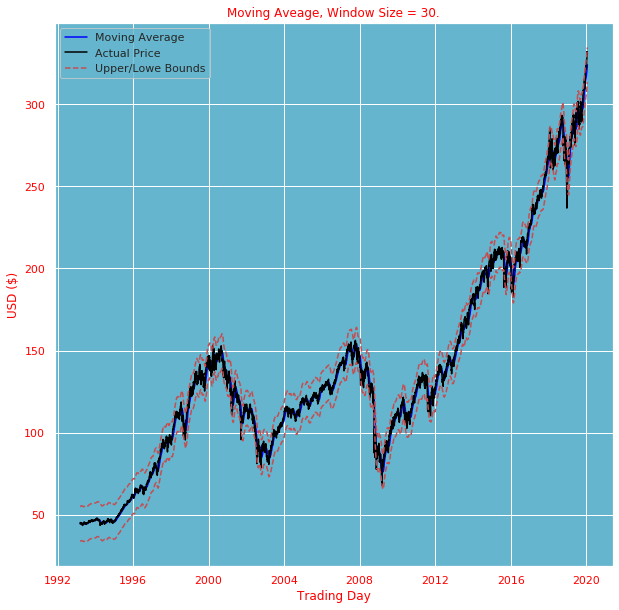

In [0]:
plt_ma(data.Average, 30, plt_int=True)

## **90-Day Moving Average**

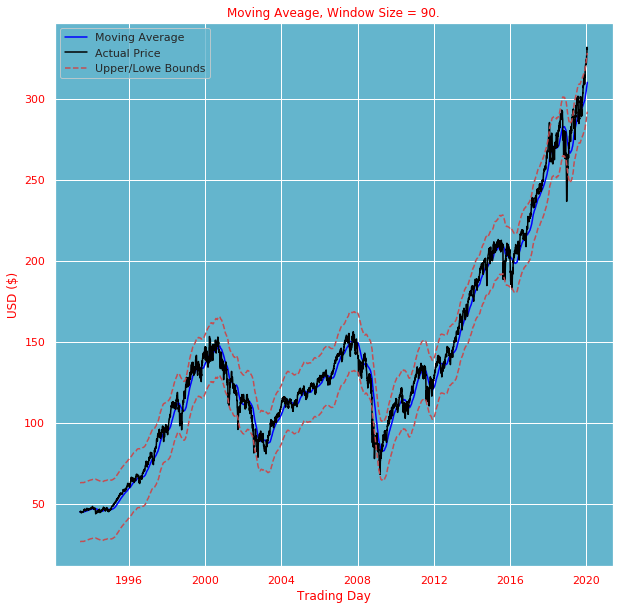

In [0]:
plt_ma(data.Average, 90, plt_int=True)

# **Let's Look Exponential Smoothing**

Exponential Smoothing involved smoothing the time-series data using an exponential window function, which takes into account the 'error' of the previous prediction(s).

The Exponential Smoothing function: **F(t + 1) = F(t) + α(Y(t) - F(t))**
where F represents the forecast, Y represents the actual value, and α represents the alpa-value--which is a value between 0 and 1.

The function can be reaggranged to the followin: **F(t + 1) = αY(t) + (1 - α)F(t)**

In [0]:
def expsmoothing (data, alpha):
  results = [data[0]]
  for i in range(1, len(data), 1):
    exp = results[i - 1] + alpha*(data[i] - results[i-1])
    results.append(exp)
  return results

def plt_exp(data, alphas):
  plt.figure(figsize=(10,10))
  plt.plot(data.values, c = 'blue', label = "Actual")
  for a in alphas:
      plt.plot(expsmoothing(data, a), label = "Alpha = {}".format(a))
  plt.title("Exponential Smoothing", c = 'red')
  plt.xlabel("Trading Day", c = "red")
  plt.ylabel("USD ($)", c = "red")
  plt.tick_params(axis = 'both', colors = 'red')
  plt.rcParams['axes.facecolor'] ='c'
  plt.axis('tight')
  plt.legend(loc = "best")
  plt.grid(True)


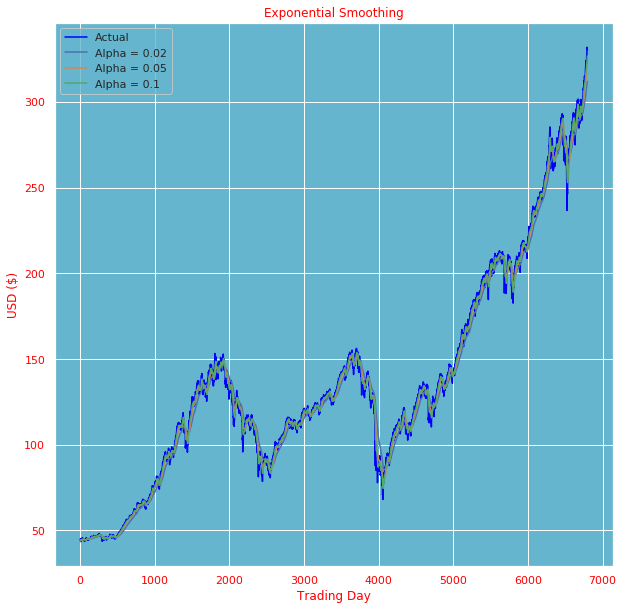

In [0]:
plt_exp(data.Average, [.02, .05, .1])

# **Let's Look at Double Exponential Smoothing**

Double Exponential Smoothing is used when there is a trend in the time-series.
The equations are as follows. 

1. **L(t) = aY(t) + (1 - a)(L(t - 1) + T(t - 1))**
2. **T(t) = b(L(t) - L(t - 1)) + (1 - b)T(t -1)**
3. **Y(t) = L(t - 1) + T(t - 1)**


In [0]:
def double_expsmoothing(data, alpha, beta):
  results = [data[0]]
  for i in range(1, len(data) + 1, 1):
    if i == 1:
      l, t = data[0], data[1] - data[0]
    if i >= len(data):
      y = results[-1]
    else:
      y = data[i]
    ll, l = l, alpha * y + (1 - alpha) * (l + t)
    t = beta * (l - ll) + (1 - beta) * t
    exp = l + t;
    results.append(exp)
  return results

def plt_dexp(data, alphas, betas):
  plt.figure(figsize = (10, 10))
  plt.plot(data.values, c = "blue", label = "Actual Prices")
  for a in alphas:
    for b in betas:
      plt.plot(double_expsmoothing(data, a, b), label = "Alpha = {}\nBeta = {}".format(a, b))
  plt.title("Double Exponential Smoothing", c = 'red')
  plt.xlabel("Trading Day", c = "red")
  plt.ylabel("USD ($)", c = "red")
  plt.tick_params(axis = 'both', colors = 'red')
  plt.rcParams['axes.facecolor'] ='c'
  plt.axis('tight')
  plt.legend(loc = "best")
  plt.grid(True)


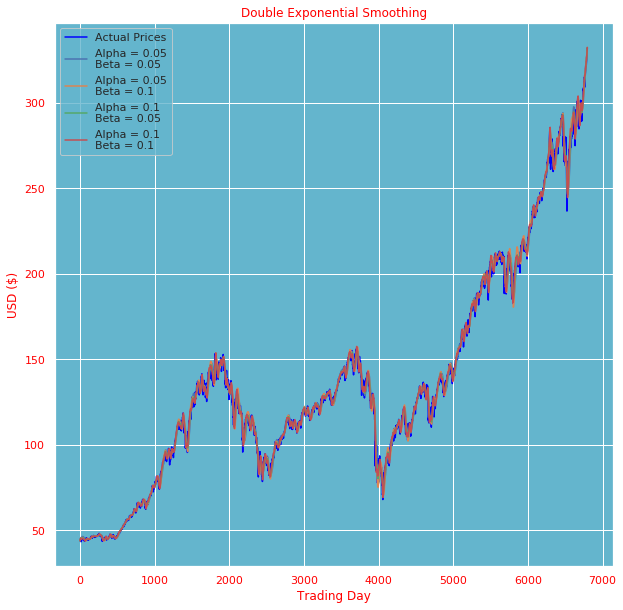

In [0]:
plt_dexp(data.Average, [.05, .1], [.05, .1])

# LSTM Model

## **Normalize and Split the Dataset**

In [0]:
#Build a Data Set
dataset = data.Average.values # Sampled over Days
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
norm = MinMaxScaler(feature_range=(0, 1))
dataset = norm.fit_transform(dataset)
train_n = int(len(dataset)*0.80)
test_n = len(dataset) - train_n
train, test = dataset[0:train_n,:], dataset[train_n:len(dataset),:]


## **Create Dataset consisting of 'Timesteps' (a Matrix)**

In [0]:
def make_ds(data, look_back):
  x, y = [], []
  for i in range(len(data) - look_back - 1):
    a = data[i:(i + look_back), 0]
    b = data[i + look_back, 0]
    x.append(a); y.append(b)
  return np.array(x), np.array(y)

In [0]:
look_back = 30;
xtrain, ytrain = make_ds(train, look_back)
xtest, ytest = make_ds(test, look_back)

## **Format Dataset to of the following Form:**
      *[Samples, Time Steps, Features]*

In [0]:
# Reshape the Matrices to be of the following form [samples, time steps, features]
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

## **Create LSTM-Sequential Model**

In [0]:
mdl = Sequential()
mdl.add(LSTM(100, input_shape = (xtrain.shape[1], xtrain.shape[2])))
mdl.add(Dropout(0.2))
mdl.add(Dense(1))
mdl.compile(loss = 'mean_squared_error', optimizer = 'adam')

history = mdl.fit(xtrain, ytrain, epochs = 25, batch_size = 300, validation_data=(xtest, ytest), callbacks = [EarlyStopping(monitor='val_loss', patience=10)], verbose = 1, shuffle = False)

mdl.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5405 samples, validate on 1329 samples
Epoch 1/25





5405/5405 [==============================] - 10s 2ms/step - loss: 0.0119 - val_loss: 0.0089
Epoch 2/25
5405/5405 [==============================] - 0s 24us/step - loss: 0.0025 - val_loss: 0.0141
Epoch 3/25
5405/5405 [==============================] - 0s 25us/step - loss: 9.0112e-04 - val_loss: 0.0024
Epoch 4/25
5405/5405 [==============================] - 0s 24us/step - loss: 9.2496e-04 - val_loss: 0.0015
Epoch 5/25
5405/5405 [==============================] - 0s 26us/step - loss: 9.6319e-04 - val_loss: 0.0010
Epoch 6/25
5405/5405 [==============================] - 0s 24us/step - loss: 6.5160e-04 - val_loss: 4.0357e-04
Epoch 7/25
5405/5405 [==============================] - 0s 25us/step - loss: 5.9124e-04 - va

## **Predictions**

In [0]:
trainpred = mdl.predict(xtrain)
testpred = mdl.predict(xtest)

trainpred = norm.inverse_transform(trainpred)
ytrain = norm.inverse_transform([ytrain])

testpred = norm.inverse_transform(testpred)
ytest = norm.inverse_transform([ytest])

print("Train Mean Absolute Error: ", mean_absolute_error(ytrain[0], trainpred[:, 0]))
print("Train RMSE: ", np.sqrt(mse(ytrain[0], trainpred[:,0])))
print("Test Mean Absolute Error: ", mean_absolute_error(ytest[0], testpred[:, 0]))
print("Test RMSE: ", np.sqrt(mse(ytest[0], testpred[:,0])))
print("\nTest Accuracy: ", predaccuracy(testpred[:,0], ytest[0]))

Train Mean Absolute Error:  2.7265107225757244
Train RMSE:  3.662754910667799
Test Mean Absolute Error:  5.975984511691878
Test RMSE:  7.814511552881243

Test Accuracy:  [106.91480987 107.13517045 108.28279238 ... 100.82978179 100.77068887
 101.15287439]


## **Visualize Predictions**

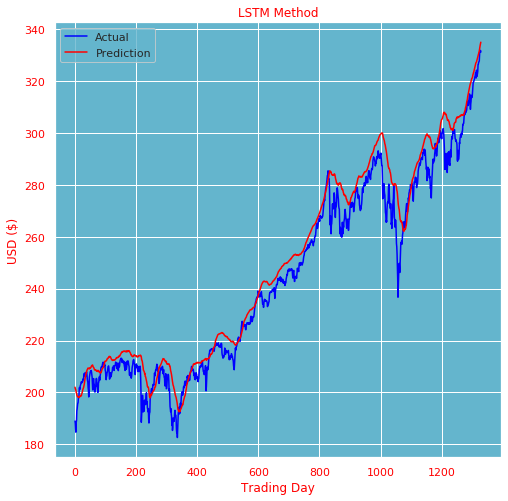

In [0]:
j = len(ytest[0])
n = [i for i in range(j)]
plt.figure(figsize = (8, 8))
plt.plot(n, ytest[0][:j], label = "Actual", c = 'blue')
plt.plot(n, testpred[:,0][:j], c = 'red', label = "Prediction")
plt.title("LSTM Method", c = 'red')
plt.xlabel("Trading Day", c = "red")
plt.ylabel("USD ($)", c = "red")
plt.tick_params(axis = 'both', colors = 'red')
plt.rcParams['axes.facecolor'] ='c'
plt.axis('tight')
plt.legend(loc = "best")
plt.grid(True)

In [0]:
pa = trendaccuracy(testpred[:,0], ytest[0])
padown, ddays = downtrendaccuracy(testpred[:,0], ytest[0])
paup, udays = uptrendaccuracy(testpred[:,0], ytest[0])

print("The daily-trend accuracy is: {}".format(pa))
print("The down daily-trend accuracy is: {}".format(padown))
print("The up daily-trend accuracy is: {}".format(paup))
print("\nThe total down days is: {}".format(ddays))
print("The total up days is: {}".format(udays))


The daily-trend accuracy is: 51.6566265060241
The down daily-trend accuracy is: 32.136752136752136
The up daily-trend accuracy is: 67.20647773279353

The total down days is: 585
The total up days is: 741


# **Conclusion**

As you can see, the LSTM method is able to predict the changes in Stock Trends over time. Unfortunately, the predictions are delayed in comparison to the actual prices--making this particular model nearly futile. But nonetheless, this was learning exercise and we can still use this particular model to predict trends given recent data. To see if our model can be of value to predict daily ups and downs, I caculated the trend accuracy. Unfortunately, as you can see that the trend accuracy is a little over 50%. Diving deeper, the model predicts up days much more accurately than down days--nearly twice as much. This can be attributed to tha fact that in recent times, the market has been performing really well. The model has become overfitted to this performance in a way.